In [2]:
# install tensorflow 
import tensorflow as tf

# demonstrating transfer learning with data augmentation

if we imagine a CNN as: 

input $→$ body (CNN) $→$ head (RNN)

where the "head" is what outputs the final prediction of regression or classification

transfer learning: when we replace the "body" with a model that's been trained on a huge dataset like ImageNet. models of this type are: 
*   VGG
*   ResNet
*   Inception
*   MobileNet

this notebook will demonstrate how to use transfer learning with one of two options for speed up: data augmentation, using the built-in function **ImageDataGenerator()**





In [3]:
# other imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import sys, os

from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel
from tensorflow.keras.applications.vgg16 import preprocess_input

from glob import glob

In [4]:
# get data (from: https://mmspg.epfl.ch/downloads/food-image-datasets/)
!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip

--2023-05-18 19:39:06--  https://lazyprogrammer.me/course_files/Food-5K.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  21.2MB/s    in 23s     

2023-05-18 19:39:30 (18.8 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [ ]:
# unzip the file (supressing output with -qq option)
!unzip -qq -o Food-5K.zip

to use the built-in function **ImageDataGenerator()**, the data needs to be in specific directories: 

*   train, which contained subdirectories labeled by category name 
*   validation or test, with the same labeled subdirectories 

the data being used should already have these directories, but check using the ls command

In [ ]:
print("directories (should include unzipped folder):")
!ls
print("")
print("directories within the unzipped folder:")
!ls Food-5K/

directories (should include unzipped folder):
Food-5K  Food-5K.zip  __MACOSX	sample_data

directories within the unzipped folder:
evaluation  training  validation


In [ ]:
# check to see what is in the training directory
!ls Food-5K/training/

0_0.jpg     0_1387.jpg	0_422.jpg  0_809.jpg   1_1195.jpg  1_230.jpg  1_617.jpg
0_1000.jpg  0_1388.jpg	0_423.jpg  0_80.jpg    1_1196.jpg  1_231.jpg  1_618.jpg
0_1001.jpg  0_1389.jpg	0_424.jpg  0_810.jpg   1_1197.jpg  1_232.jpg  1_619.jpg
0_1002.jpg  0_138.jpg	0_425.jpg  0_811.jpg   1_1198.jpg  1_233.jpg  1_61.jpg
0_1003.jpg  0_1390.jpg	0_426.jpg  0_812.jpg   1_1199.jpg  1_234.jpg  1_620.jpg
0_1004.jpg  0_1391.jpg	0_427.jpg  0_813.jpg   1_119.jpg   1_235.jpg  1_621.jpg
0_1005.jpg  0_1392.jpg	0_428.jpg  0_814.jpg   1_11.jpg    1_236.jpg  1_622.jpg
0_1006.jpg  0_1393.jpg	0_429.jpg  0_815.jpg   1_1200.jpg  1_237.jpg  1_623.jpg
0_1007.jpg  0_1394.jpg	0_42.jpg   0_816.jpg   1_1201.jpg  1_238.jpg  1_624.jpg
0_1008.jpg  0_1395.jpg	0_430.jpg  0_817.jpg   1_1202.jpg  1_239.jpg  1_625.jpg
0_1009.jpg  0_1396.jpg	0_431.jpg  0_818.jpg   1_1203.jpg  1_23.jpg   1_626.jpg
0_100.jpg   0_1397.jpg	0_432.jpg  0_819.jpg   1_1204.jpg  1_240.jpg  1_627.jpg
0_1010.jpg  0_1398.jpg	0_433.jpg  0_81.jpg    1_1205.j

it appears all the images of one class begin with "0_" and the other class begins with "1_"

this dataset has two classes: 
0.   Images without food
1.   Images with food

plot some images just to be sure they are correctly classified 

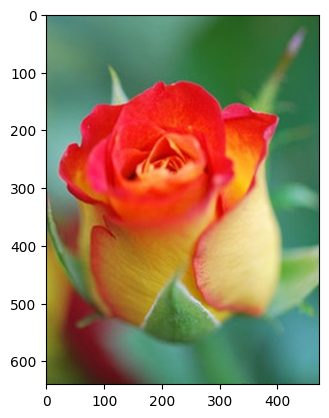

In [ ]:
# plot an image without food
plt.imshow(image.load_img('Food-5K/training/0_808.jpg'))
plt.show()

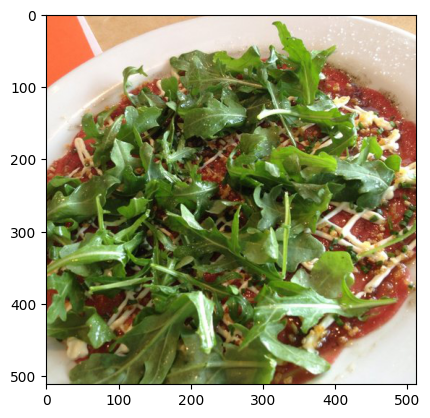

In [ ]:
# plot an image with food
plt.imshow(image.load_img('Food-5K/training/1_617.jpg'))
plt.show()

for the **ImageDataGenerator()** function, the two subdirectories train and test need to be in a larger directory called "data", so make the directory and move the folders around: 

In [ ]:
!mkdir data
!mkdir data/train
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test
!mkdir data/test/nonfood
!mkdir data/test/food 

In [ ]:
# now move files into appropriate folders
!mv Food-5K/training/0*.jpg data/train/nonfood/
!mv Food-5K/training/1*.jpg data/train/food/
!mv Food-5K/validation/0*.jpg data/test/nonfood/
!mv Food-5K/validation/1*.jpg data/test/food/

# ignore the 3rd directory "evaluation"

In [ ]:
train_path = 'data/train'
test_path = 'data/test'

now we want to ensure the images are all the same size, which we'll choose as (200, 200)

In [ ]:
imagesize = [200,200]

In [ ]:
# easy path to files
image_files = glob(train_path + '/*/*.jpg')
test_image_files = glob(test_path + '/*/*.jpg')

# classes
folders = glob(train_path + '/*')
folders

['data/train/food', 'data/train/nonfood']

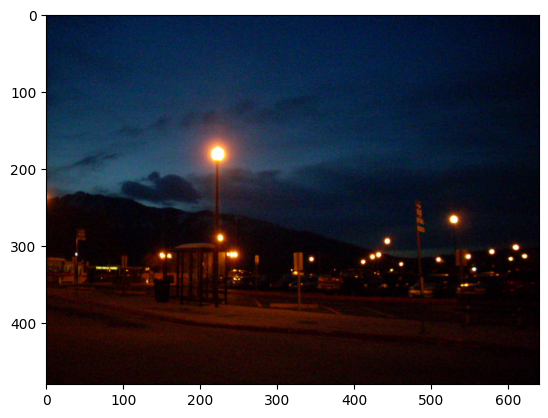

In [ ]:
# plot a random image from the train set to ensure all paths work
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

now that the data is in the correct form, move onto the pre-trained model (VGG16)

In [ ]:
ptm = PretrainedModel(input_shape=imagesize+[3], # dimension of images + 3 (color channgels)
                      weights='imagenet',        # want weights from ImageNet
                      include_top=False)         # get layers up to final convolution (i.e. only body)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# freeze the pre-trained model's weights
ptm.trainable = False

In [ ]:
# now, create the head of the network
# ImageDataGenerator() returns classes one-hot encoded
# need to map the data into feature vectors
K = len(folders)
x = Flatten()(ptm.output)
x = Dense(K, activation='softmax')(x)

note: why use softmax instead of sigmoid (as we're doing binary classification)? 

softmax is the default when the targets are one-hot encoded and for K-class classification (K /= 2). it's also preferred for this API

In [ ]:
# create model
model = Model(inputs=ptm.inputs, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [ ]:
# create ImageDataGenerator instance 
gen = ImageDataGenerator(rotation_range=20,
                         width_shift_range=0.1, 
                         height_shift_range=0.1,
                         shear_range=0.1,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         preprocessing_function=preprocess_input)

In [ ]:
# create generators
batchsize = 128
train_generator = gen.flow_from_directory(train_path,               # path to folder
                                          shuffle=True,             # only on train
                                          target_size=imagesize,    # all images same size
                                          batch_size=batchsize)     # specified above 
test_generator = gen.flow_from_directory(test_path,
                                         target_size=imagesize,
                                         batch_size=batchsize)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# now compile 
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

note: categorical cross entropy is used as the loss frunction over sparse categorical cross entropy, as the generator generates the targets as one-hot encoded

In [ ]:
# and fit (fit can be used over fit_generator as fit supports generators)
r = model.fit(train_generator, 
              validation_data=test_generator, 
              epochs=10,
              steps_per_epoch=int(np.ceil(len(image_files)/batchsize)),
              validation_steps=int(np.ceil(len(test_image_files)/batchsize)))

NameError: ignored